In [14]:
from expert_data import*
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler

env_name = 'CartPole-v1'
env = gym.make(env_name)
env.reset(seed=0)
torch.manual_seed(0)
random.seed(0)

expert_agent,return_list=train_expert_agent(env)

Iteration 9: 100%|██████████| 25/25 [00:03<00:00,  8.16it/s, episode=245, return=488.800]


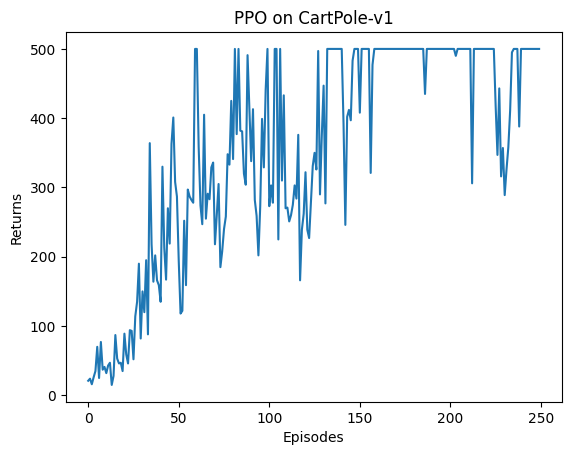

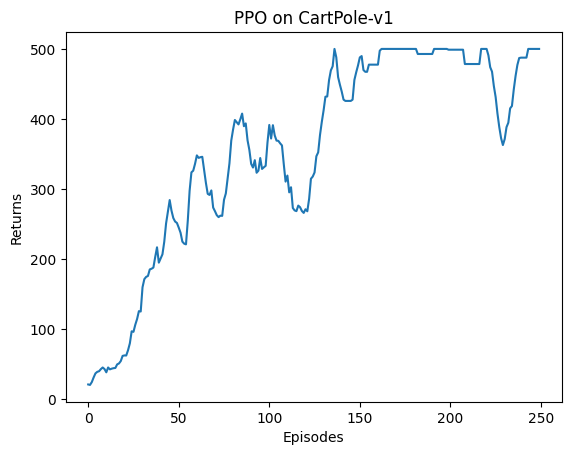

In [15]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO on {}'.format(env_name))
plt.show()

In [16]:
n_episode = 20
print("Sampling expert data...")
expert_trajectories = sample_expert_data(env, expert_agent, n_episode)

Sampling expert data...


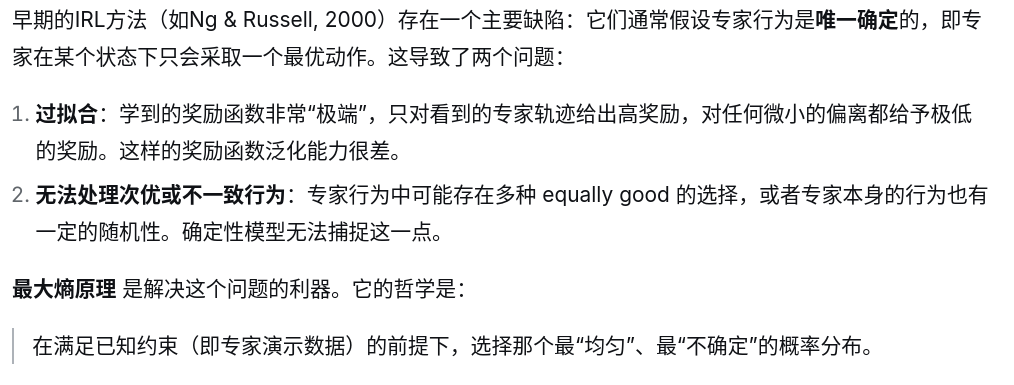  
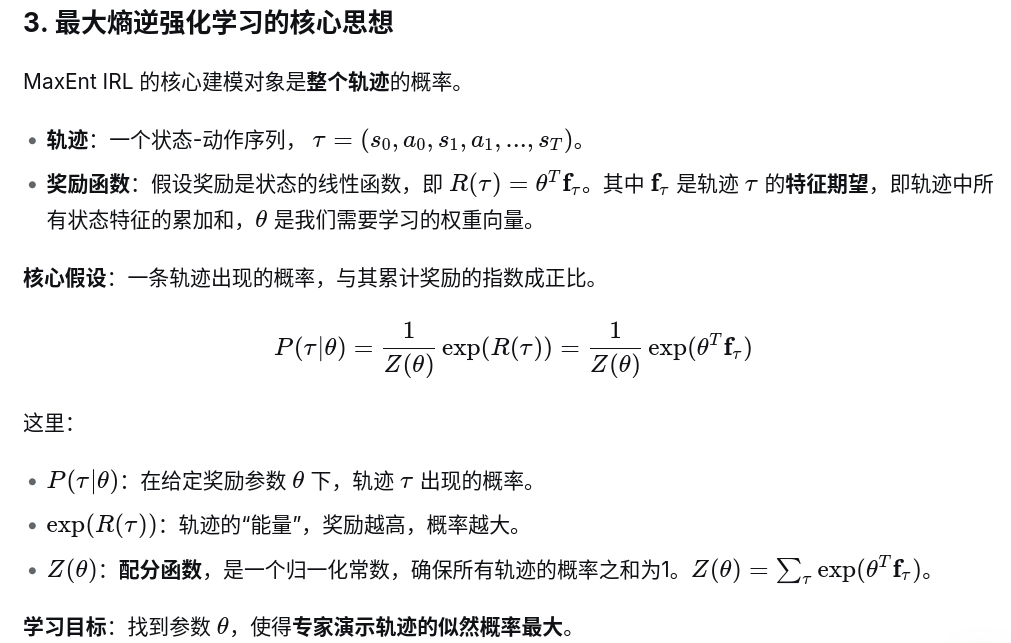  
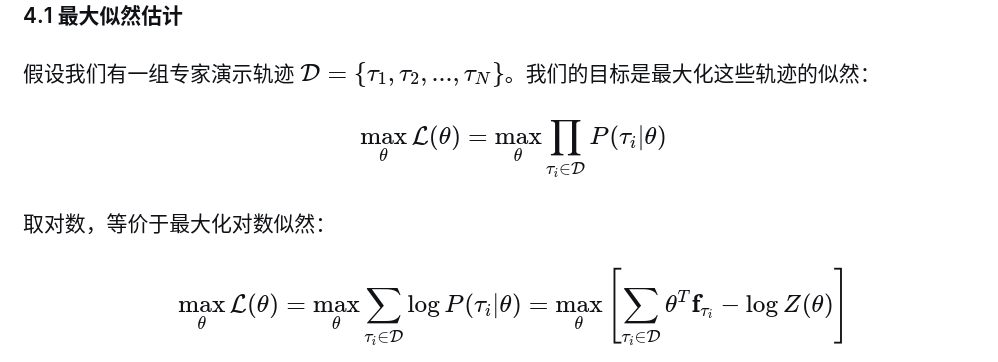  

使用最大似然估计就是计算交叉熵  

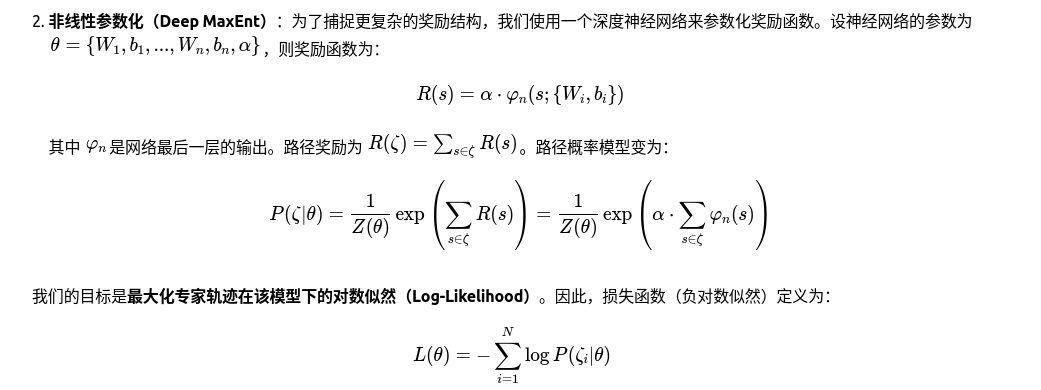  
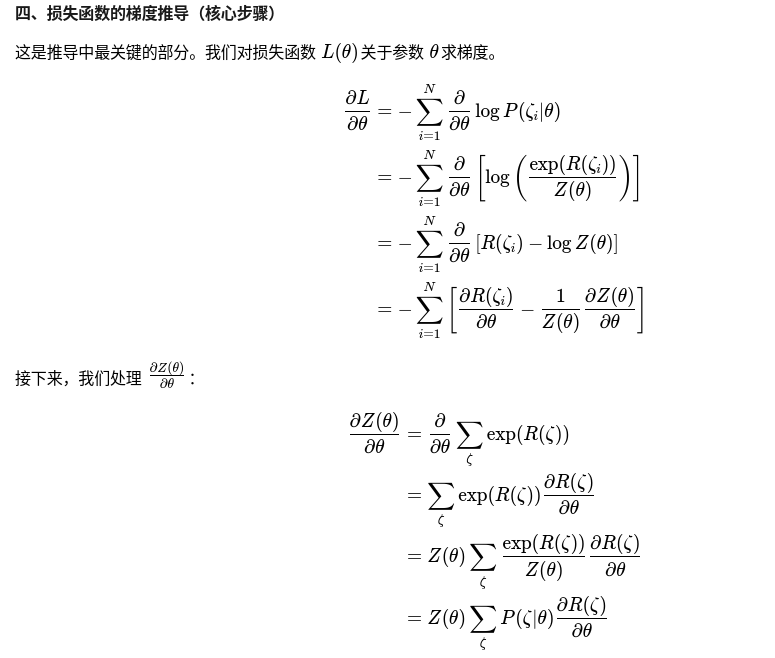
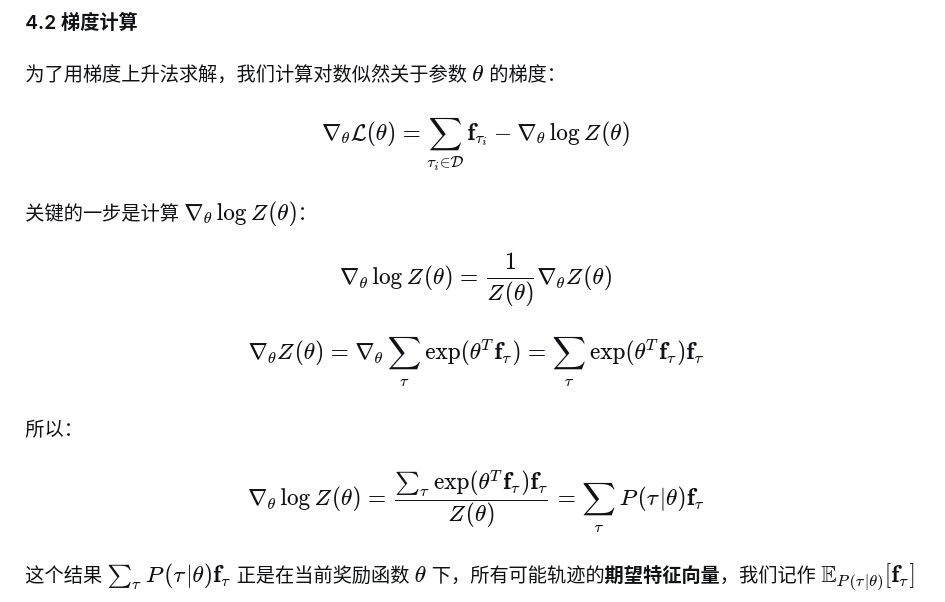

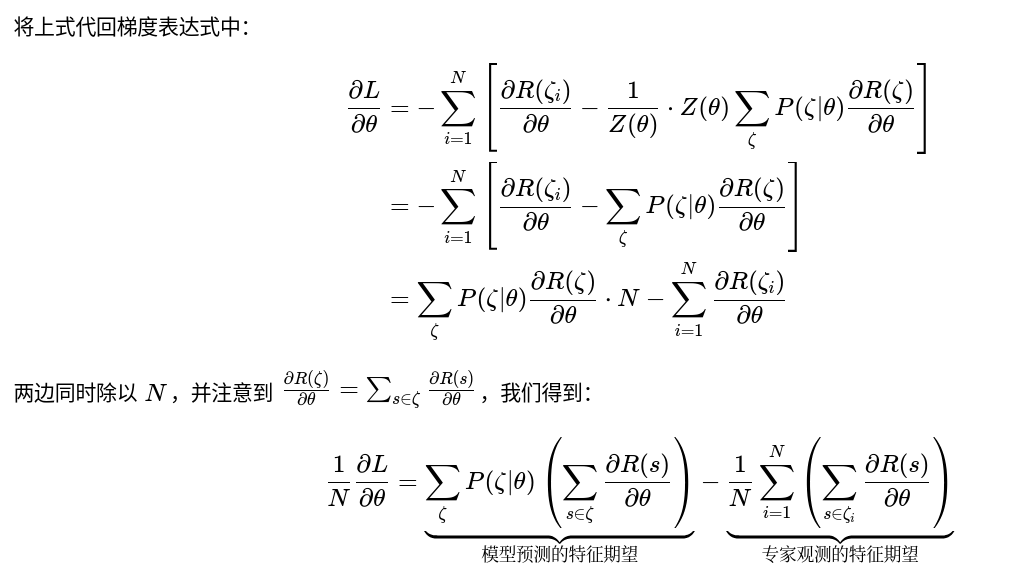  
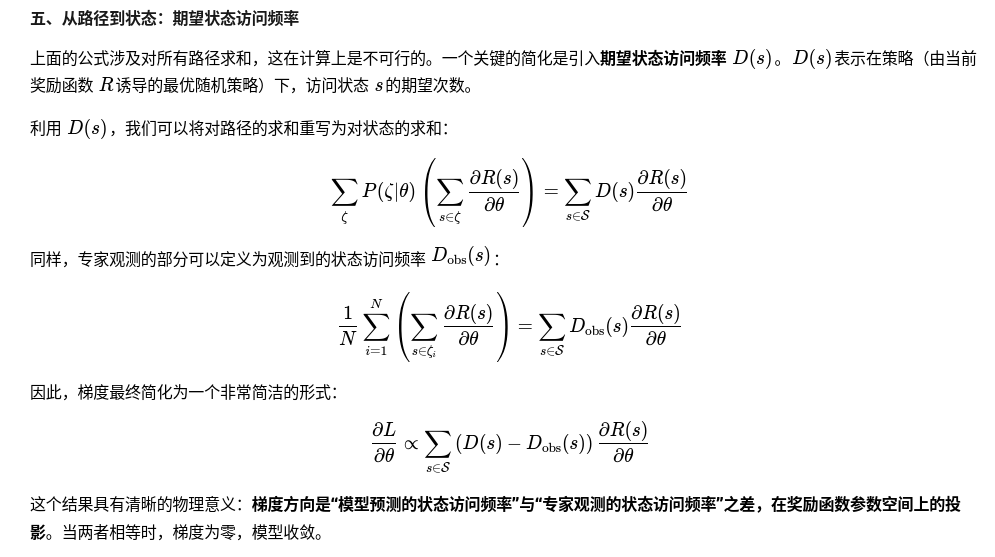   
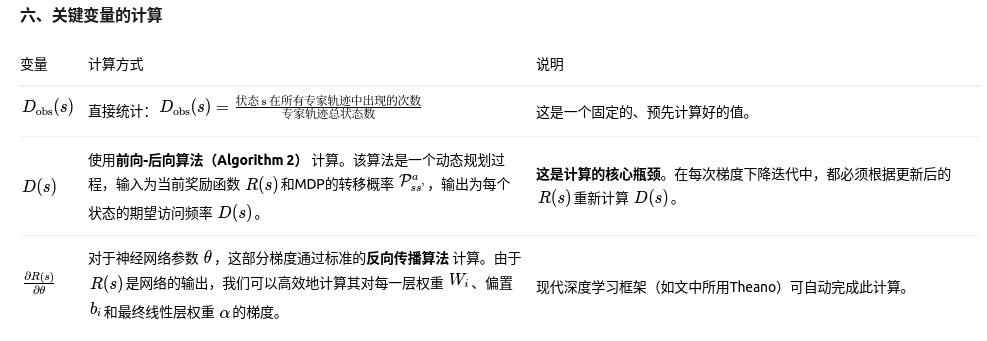

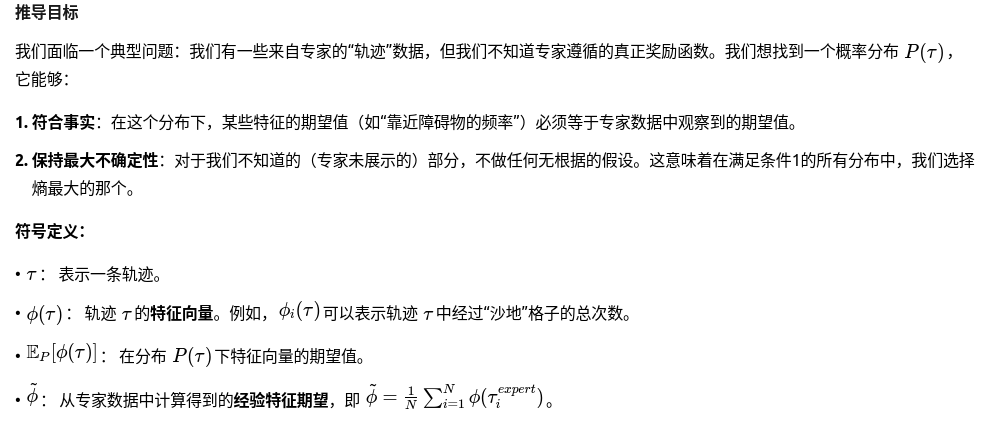  
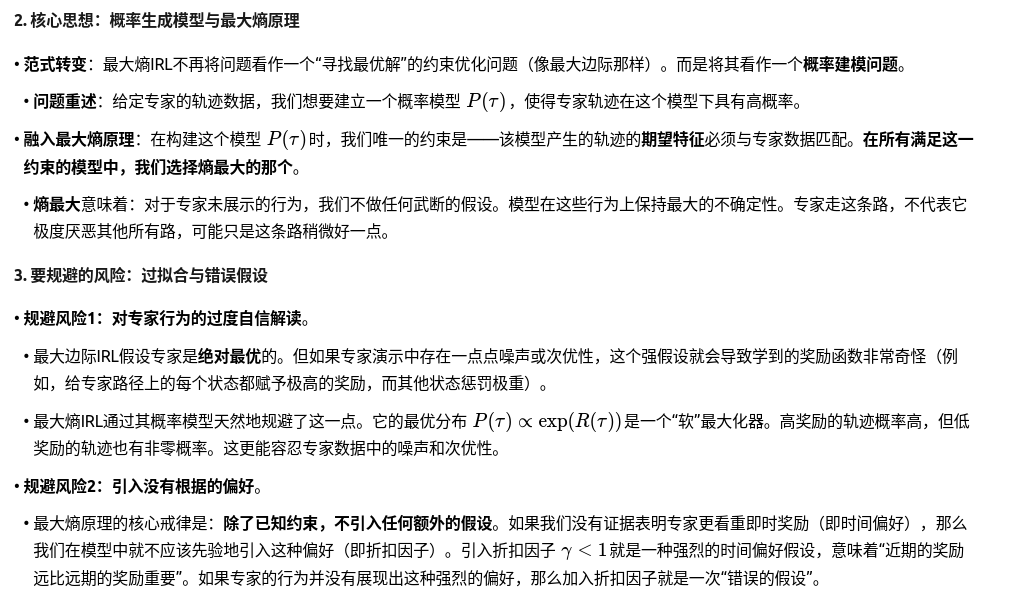  
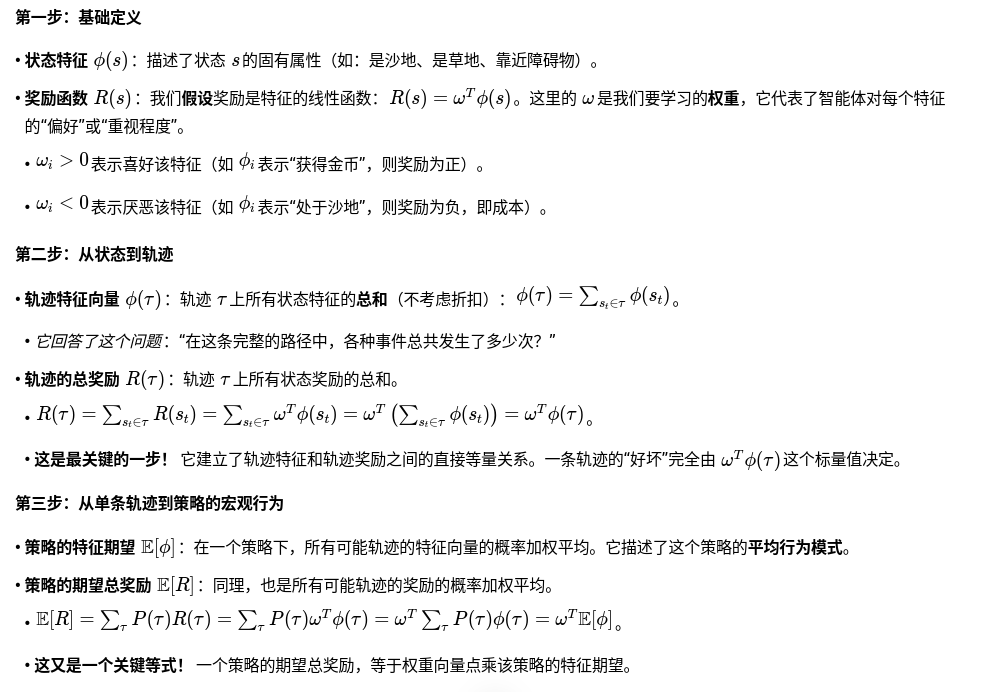   
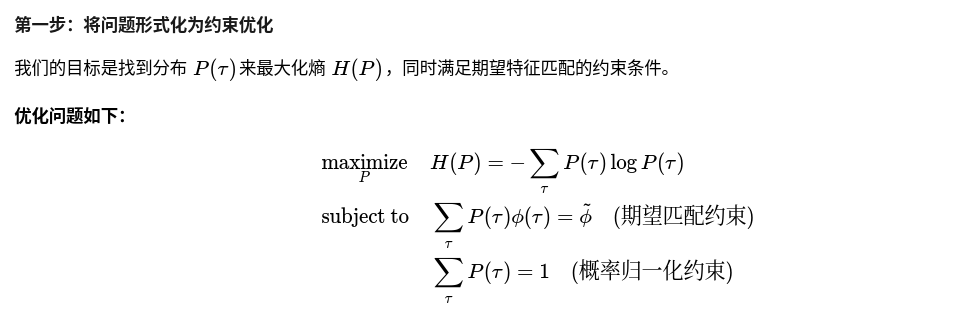  
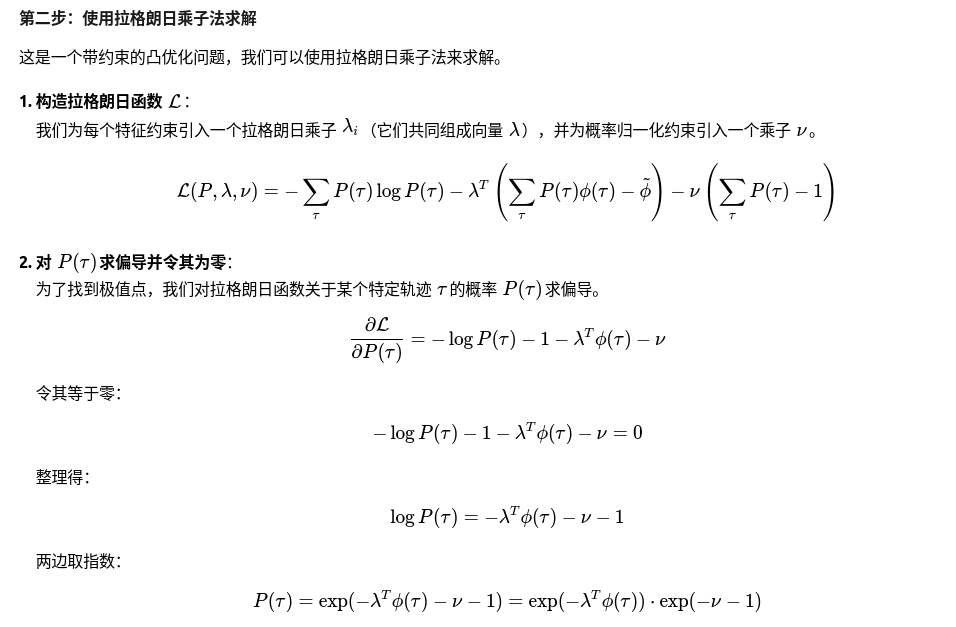  
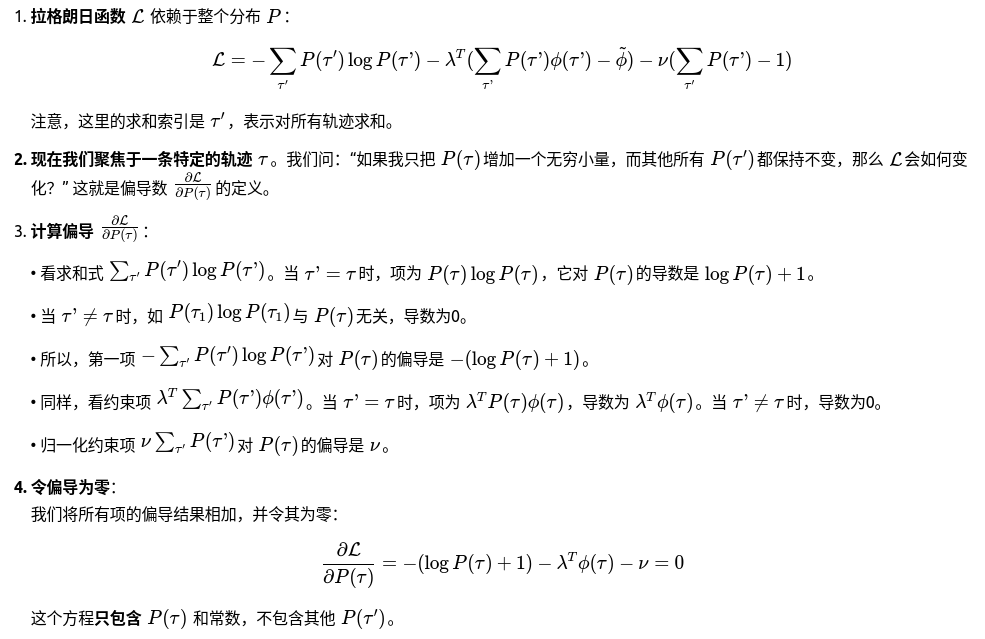  
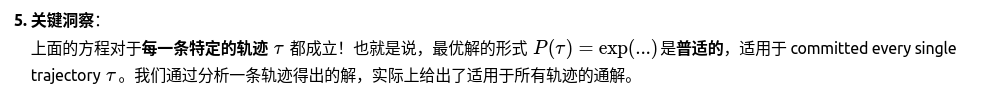  
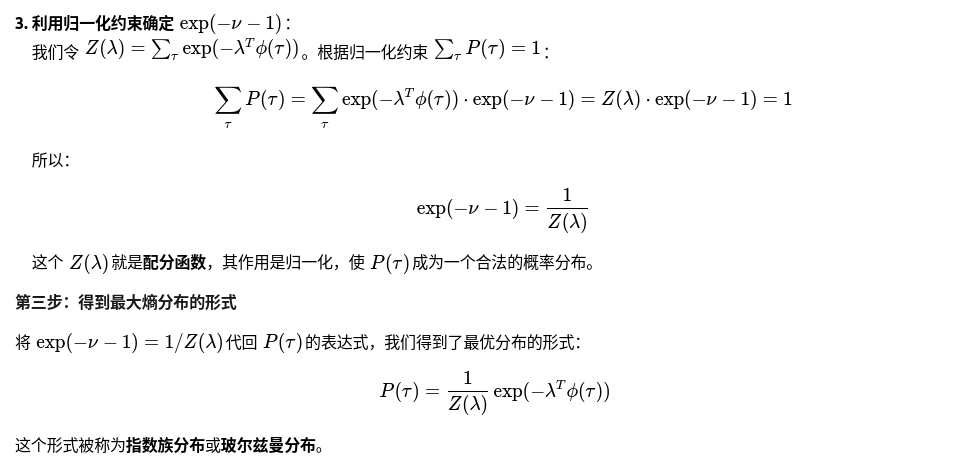  
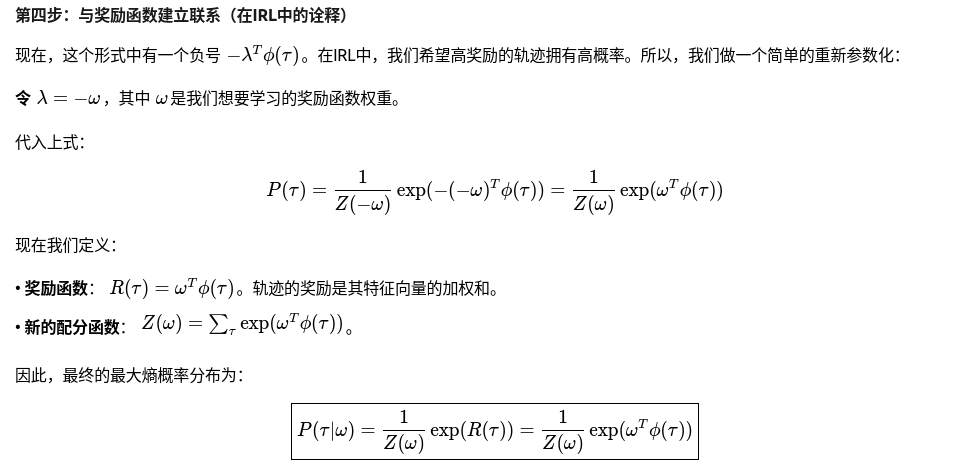  
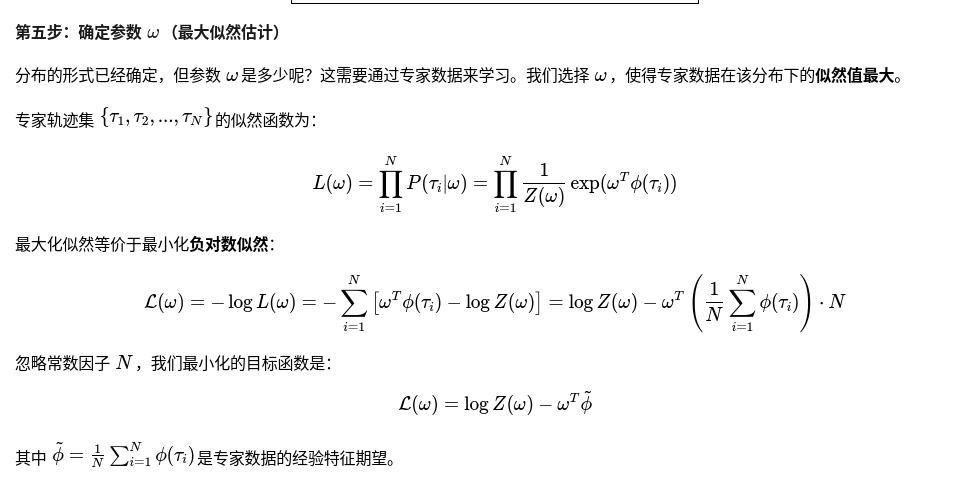  
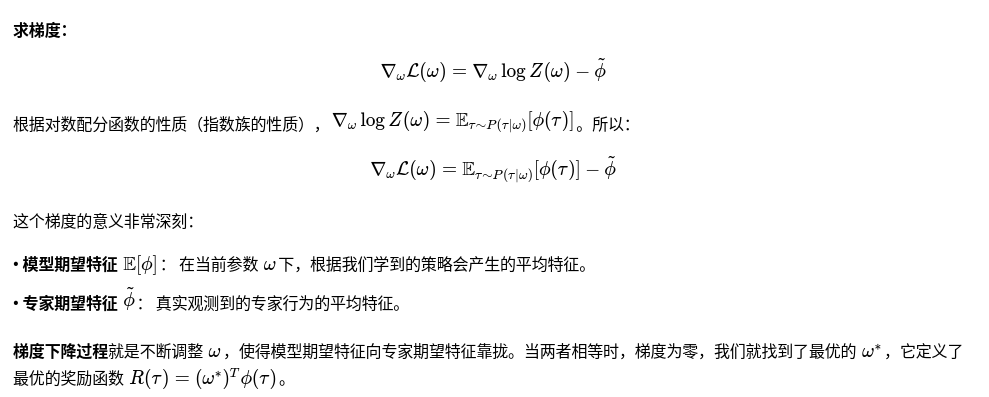

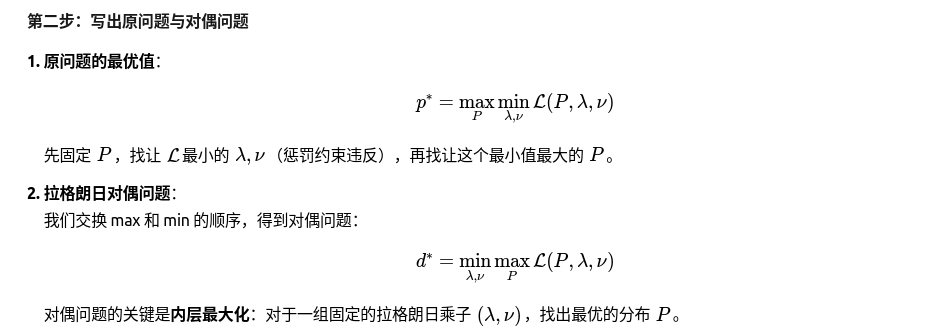  
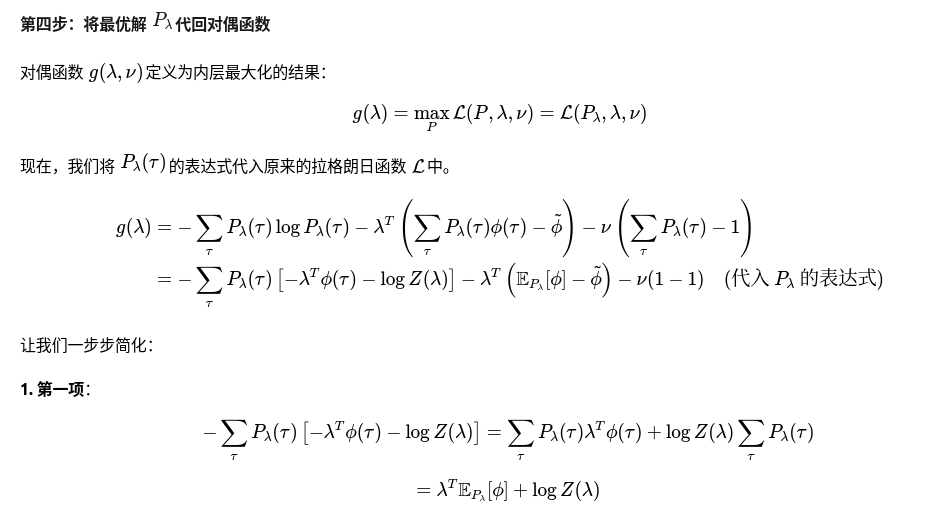  
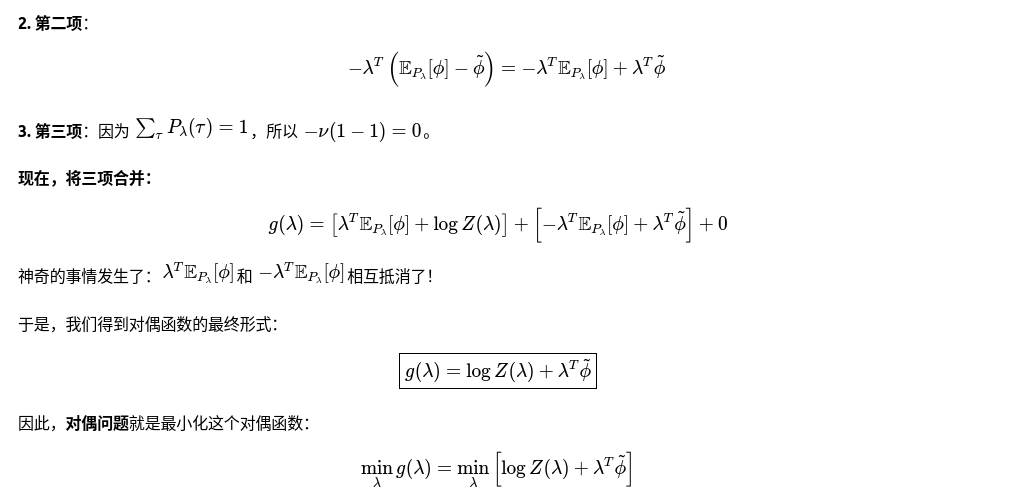  
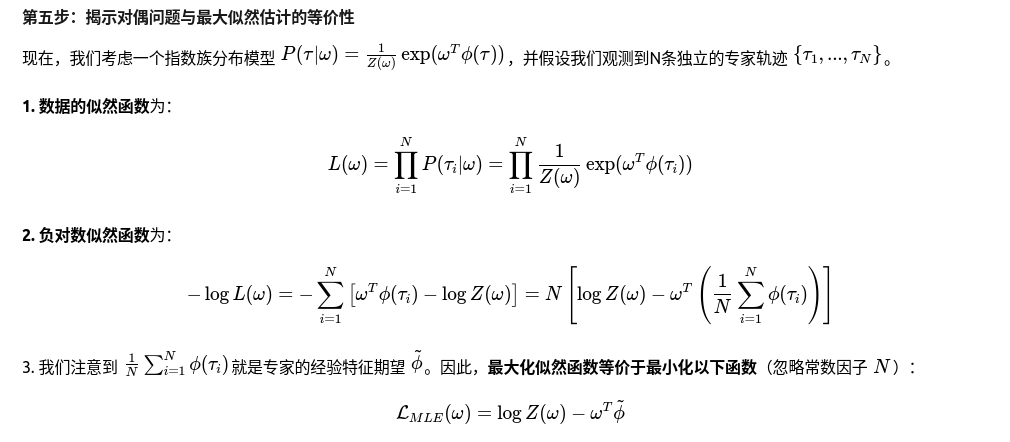  
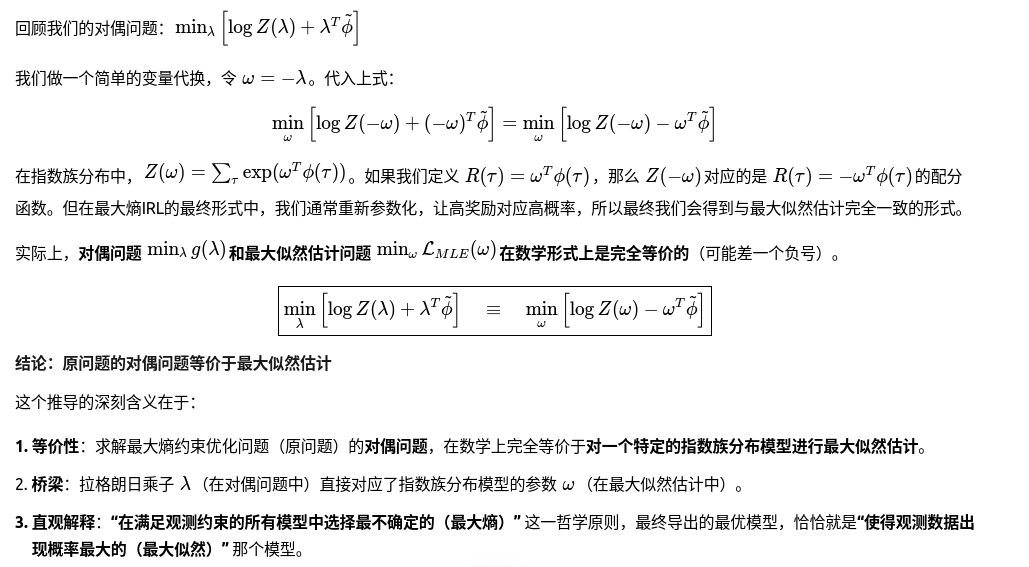

In [48]:
import torch
import torch.nn as nn
import torch.optim as optim

class MaxEntIRL:
    def __init__(self, state_dim, hidden_dim, action_dim, expert_trajectories,
                 actor_lr, critic_lr, lmbda, epochs, eps, device, gamma=1.0, 
                 n_features=None, irl_lr=0.01):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.device = device
        self.irl_lr = irl_lr
        self.gamma = gamma
        self.expert_trajectories = expert_trajectories
        if n_features is None:
            n_features = state_dim
        self.n_features = n_features
        # 初始化PPO agent
        self.ppo_agent = PPO(state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                            lmbda, epochs, eps, gamma, device)
        # 初始化奖励函数权重
        self.weights = nn.Parameter(torch.randn(n_features, device=device))
        self.optimizer = optim.Adam([self.weights], lr=irl_lr)
        # 特征标准化器
        self.scaler = StandardScaler()
        self._fit_scaler()
        # 预计算专家特征期望
        self.expert_features = self._compute_expert_feature_expectations()
    
    def _fit_scaler(self):
        """用专家数据拟合标准化器"""
        all_states = []
        for trajectory in self.expert_trajectories:
            all_states.extend(trajectory['states'])
        if all_states:
            self.scaler.fit(np.array(all_states))

    def feature_vector(self, state):
        """计算特征向量"""
        if len(state.shape) == 1:
            state = state.reshape(1, -1)
        return self.scaler.transform(state)
    
    def _compute_expert_feature_expectations(self):
        """预计算专家特征期望"""
        trajectory_features = []
        for trajectory in self.expert_trajectories:
            states = trajectory['states']
            discount = 1.0
            features = self.feature_vector(states)
            # 特征向量形状为(episode_num_step,feature_dim)
            discounted_features=np.zeros(features.shape[1])
            # 计算折扣累积特征
            # (feature_dim,)
            # 计算单条轨迹的折扣累积特征
            for i in range(len(features)):
                discounted_features += discount * features[i]
                discount *= self.gamma
            # 轨迹的累积特征向量
            trajectory_features.append(discounted_features)
        expert_features = np.mean(trajectory_features, axis=0)
        return torch.Tensor(expert_features).to(self.device).detach()
    
    
    def train_policy_with_current_reward(self, env, num_episodes):
        """使用当前奖励函数训练策略"""
        buffer_size = 10000
        minimal_size= 500
        batch_size = 64
        replay_buffer = rl_utils.ReplayBuffer(buffer_size)
        return_list = []
        for episode in range(num_episodes):
            state = env.reset()[0]
            done = False
            while not done:
                action = self.ppo_agent.take_action(state)
                next_state, _, done, truncated, _ = env.step(action)
                done = done or truncated
                # 使用学到的奖励函数
                reward = self.compute_reward(state)
                replay_buffer.add(state, action, reward, next_state, done)
                if replay_buffer.size() > minimal_size:
                    b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                    transition_dict = {'states': b_s, 'actions': b_a, 'next_states': b_ns, 'rewards': b_r, 'dones': b_d}
                    # 更新PPO agent  
                    self.ppo_agent.update(transition_dict)
                state = next_state
        return_list=self.evaluate(env)
        return return_list
    
    def collect_policy_trajectories(self, env, num_episodes):
        """收集策略的轨迹数据（保留轨迹结构）"""
        trajectories = []
        for episode in range(num_episodes):
            state = env.reset()[0]
            done = False
            trajectory = {
                'states': [],
                'actions': []
            }
            while not done:
                action = self.ppo_agent.take_action(state)
                next_state, _, done, truncated, _ = env.step(action)
                done = done or truncated
                trajectory['states'].append(state)
                trajectory['actions'].append(action)
                state = next_state
            # 转换为numpy数组
            trajectory['states'] = np.array(trajectory['states'])
            trajectory['actions'] = np.array(trajectory['actions'])
            trajectories.append(trajectory)
        return trajectories
    
    def evaluate(self, env, num_episodes=10):
        """评估学到的策略"""
        total_returns = []
        for _ in range(num_episodes):
            state = env.reset()[0]
            done = False
            episode_return = 0
            while not done:
                action = self.ppo_agent.take_action(state)
                next_state, reward, done, truncated, _ = env.step(action)
                done = done or truncated
                episode_return += reward
                state = next_state
            total_returns.append(episode_return)
        return float(np.mean(total_returns))
    
    def compute_reward(self,state):
        # R(s) = w^T φ(s)
        feature= torch.Tensor(self.feature_vector(state)).to(self.device).view(-1)
        reward=torch.dot(feature, self.weights)
        return reward.detach()
    
    def compute_episode_reward(self, states):
        """根据当前权重计算奖励 - 完全在PyTorch中计算"""
        feature_vectors = self.feature_vector(states)
        # (episode_num_step,feature_dim)
        features = torch.Tensor(feature_vectors).to(self.device)
        episode_feature=features.sum(dim=0)
        # (feature_dim)
        # 计算奖励：R(s) = w^T φ(t)
        episode_return = torch.dot(episode_feature, self.weights)
        return episode_return
    
    def compute_policy_feature_expectations(self,env, num_trajectories=20):
        """计算策略的特征期望 """
        # 收集轨迹数据
        trajectories = self.collect_policy_trajectories(env, num_trajectories)
        total_return=0
        for trajectory in trajectories:
            states = trajectory['states']
            if len(states) == 0:
                continue
            episode_return=self.compute_episode_reward(states)
            episode_return=torch.exp(episode_return)
            total_return+=episode_return
        return torch.log(total_return)
    
    def maxent_loss(self, log_z_w):
        """最大熵损失函数"""
        loss = log_z_w - torch.dot(self.weights,self.expert_features)
        return loss
    
    def train(self, env, num_iterations=50, num_policy_trajectories=10, eval_interval=5):
        """训练最大熵IRL算法"""
        return_lists = []
        for iteration in tqdm(range(num_iterations)):
            # 1. 使用当前奖励函数训练策略
            returns=self.train_policy_with_current_reward(env, num_episodes=3)
            # 2. 计算当前策略的对数配分函数
            log_z_w = self.compute_policy_feature_expectations(env,num_policy_trajectories)
            # 3. 计算损失
            loss = self.maxent_loss(log_z_w)
            # 4. 反向传播
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            return_lists.append(returns)
        returns=self.evaluate(env)
        return_lists.append(returns)
        return return_lists

损失函数：  
$$L(w)=\log(\sum_{\tau}exp(w^T*\phi(\tau)))-w^T\hat {\phi}$$

In [49]:
# 设置超参数
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
hidden_dim = 128
actor_lr = 1e-3
critic_lr = 1e-2
gamma = 0.98
lmbda = 0.95
epochs = 10
eps = 0.2
irl_lr = 0.1

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# 创建最大熵IRL智能体
maxent_agent = MaxEntIRL(
    state_dim=state_dim,
    hidden_dim=hidden_dim,
    action_dim=action_dim,
    expert_trajectories=expert_trajectories,
    actor_lr=actor_lr,
    critic_lr=critic_lr,
    lmbda=lmbda,
    epochs=epochs,
    eps=eps,
    device=device,
    irl_lr=irl_lr
)

In [50]:
# 训练最大熵IRL
return_lists = maxent_agent.train(env, num_iterations=300)


100%|██████████| 300/300 [00:40<00:00,  7.42it/s]


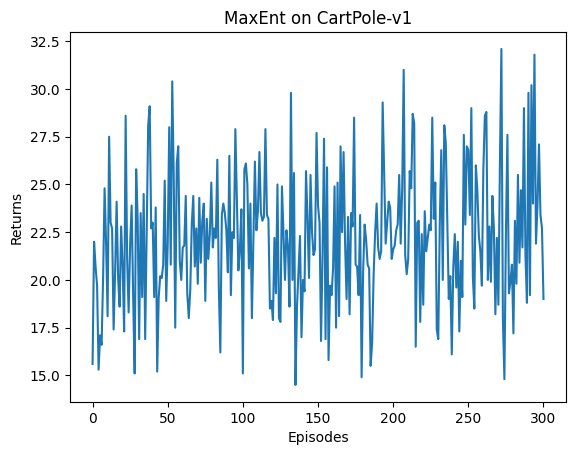

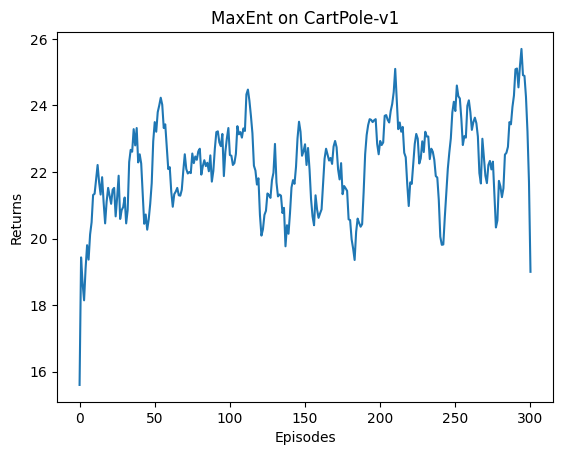

In [51]:
# 可视化训练过程
episodes_list = list(range(len(return_lists)))
plt.plot(episodes_list, return_lists)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('MaxEnt on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_lists, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('MaxEnt on {}'.format(env_name))
plt.show()

可以看到，策略效果非常差，原因是基函数过于简单，
由于线性的映射找不到合适的基函数，并且基函数不好选取，因此使用神经网络进行替代

In [68]:
class RewardNet(nn.Module):
    """深度奖励网络"""
    def __init__(self,state_dim, hidden_dim):
        super().__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc_out = torch.nn.Linear(hidden_dim, 1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x=  F.relu(self.fc2(x))
        return self.fc_out(x)

In [69]:
class DeepMaxEntIRL:
    def __init__(self, state_dim, hidden_dim, action_dim, expert_trajectories,
                 actor_lr, critic_lr, lmbda, epochs, eps, device, gamma=1.0, 
                 n_features=None, irl_lr=0.01):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.device = device
        self.irl_lr = irl_lr
        self.gamma = gamma
        self.expert_trajectories = expert_trajectories
        if n_features is None:
            n_features = state_dim
        self.n_features = n_features
        # 初始化PPO agent
        self.ppo_agent = PPO(state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                            lmbda, epochs, eps, gamma, device)
        # 初始化奖励函数
        self.reward_net=RewardNet(state_dim,hidden_dim).to(device)
        self.optimizer = optim.Adam(self.reward_net.parameters(), lr=irl_lr)
   
    def train_policy_with_current_reward(self, env, num_episodes):
        """使用当前奖励函数训练策略"""
        buffer_size = 10000
        minimal_size= 500
        batch_size = 64
        replay_buffer = rl_utils.ReplayBuffer(buffer_size)
        return_list = []
        self.reward_net.eval()
        for episode in range(num_episodes):
            state = env.reset()[0]
            done = False
            while not done:
                action = self.ppo_agent.take_action(state)
                next_state, _, done, truncated, _ = env.step(action)
                done = done or truncated
                # 使用学到的奖励函数
                ts_state=torch.Tensor(state).to(self.device).view(1,-1)
                reward = self.reward_net(ts_state)
                replay_buffer.add(state, action, reward, next_state, done)
                if replay_buffer.size() > minimal_size:
                    b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                    transition_dict = {'states': b_s, 'actions': b_a, 'next_states': b_ns, 'rewards': b_r, 'dones': b_d}
                    # 更新PPO agent  
                    self.ppo_agent.update(transition_dict)
                state = next_state
        return_list=self.evaluate(env)
        return return_list
    
    def collect_policy_trajectories(self, env, num_episodes):
        """收集策略的轨迹数据（保留轨迹结构）"""
        trajectories = []
        for episode in range(num_episodes):
            state = env.reset()[0]
            done = False
            trajectory = {
                'states': [],
                'actions': []
            }
            while not done:
                action = self.ppo_agent.take_action(state)
                next_state, _, done, truncated, _ = env.step(action)
                done = done or truncated
                trajectory['states'].append(state)
                trajectory['actions'].append(action)
                state = next_state
            # 转换为numpy数组
            trajectory['states'] = np.array(trajectory['states'])
            trajectory['actions'] = np.array(trajectory['actions'])
            trajectories.append(trajectory)
        return trajectories
    
    def evaluate(self, env, num_episodes=5):
        """评估学到的策略"""
        total_returns = []
        for _ in range(num_episodes):
            state = env.reset()[0]
            done = False
            episode_return = 0
            while not done:
                action = self.ppo_agent.take_action(state)
                next_state, reward, done, truncated, _ = env.step(action)
                done = done or truncated
                episode_return += reward
                state = next_state
            total_returns.append(episode_return)
        return float(np.mean(total_returns))
    
    def compute_episode_reward(self, states):
        """根据当前权重计算奖励 """
        states=torch.Tensor(states).to(self.device)
        # (num_episode_step,1)
        rewards=self.reward_net(states)
        episode_return=rewards.sum(dim=0)
        return episode_return
    

    def compute_policy_feature_expectations(self,env, num_trajectories=20):
        """计算策略的特征期望 """
        # 收集轨迹数据
        trajectories = self.collect_policy_trajectories(env, num_trajectories)
        total_return=0
        for trajectory in trajectories:
            states = trajectory['states']
            if len(states) == 0:
                continue
            episode_return=self.compute_episode_reward(states)
            episode_return=torch.exp(episode_return)
            total_return+=episode_return
        return torch.log(total_return)
    
    def compute_expert_return_expectations(self):
        trajectories = self.expert_trajectories
        total_return=0
        for trajectory in trajectories:
            states = trajectory['states']
            if len(states) == 0:
                continue
            episode_return=self.compute_episode_reward(states)
            total_return+=episode_return
        return torch.mean(total_return)

    def maxent_loss(self, log_z_w):
        """最大熵损失函数"""
        loss = log_z_w - self.compute_expert_return_expectations()
        return loss
    
    def train(self, env, num_iterations=50, num_policy_trajectories=10, eval_interval=5):
        """训练最大熵IRL算法"""
        return_lists = []
        for iteration in tqdm(range(num_iterations)):
            # 1. 使用当前奖励函数训练策略
            returns=self.train_policy_with_current_reward(env, num_episodes=3)
            self.reward_net.train()
            # 2. 计算当前策略的对数配分函数
            log_z_w = self.compute_policy_feature_expectations(env,num_policy_trajectories)
            # 3. 计算损失
            loss = self.maxent_loss(log_z_w)
            # 4. 反向传播
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            return_lists.append(returns)
        returns=self.evaluate(env)
        return_lists.append(returns)
        return return_lists

In [70]:
Deepmaxent_agent = DeepMaxEntIRL(
    state_dim=state_dim,
    hidden_dim=hidden_dim,
    action_dim=action_dim,
    expert_trajectories=expert_trajectories,
    actor_lr=actor_lr,
    critic_lr=critic_lr,
    lmbda=lmbda,
    epochs=epochs,
    eps=eps,
    device=device,
    irl_lr=irl_lr
)
return_lists = Deepmaxent_agent.train(env, num_iterations=300)

100%|██████████| 300/300 [00:31<00:00,  9.55it/s]


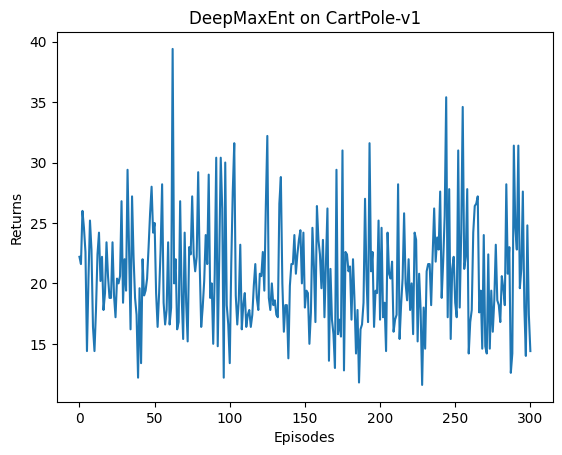

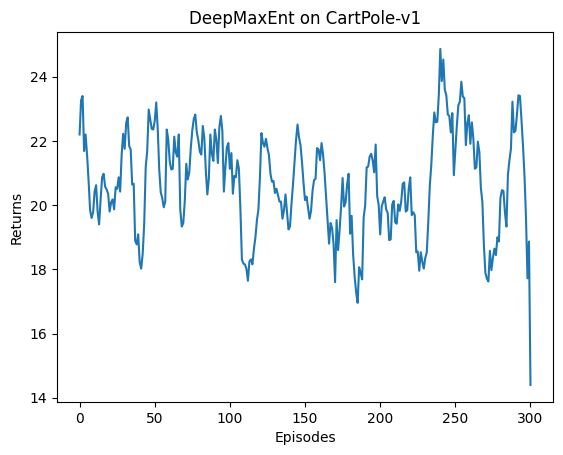

In [72]:
# 可视化训练过程
episodes_list = list(range(len(return_lists)))
plt.plot(episodes_list, return_lists)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DeepMaxEnt on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_lists, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DeepMaxEnt on {}'.format(env_name))
plt.show()

In [73]:
import gymnasium as gym
import torch
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import rl_utils
from collections import defaultdict

class RewardNetwork(nn.Module):
    """深度奖励网络，对应文档中的公式37-39"""
    def __init__(self, state_dim, hidden_dims=[64, 32]):
        super(RewardNetwork, self).__init__()
        layers = []
        prev_dim = state_dim
        
        # 构建深度网络结构
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.Sigmoid())  # 使用Sigmoid激活函数
            prev_dim = hidden_dim
        
        # 输出层，对应文档中的α·φ_n(s)
        layers.append(nn.Linear(prev_dim, 1))
        self.network = nn.Sequential(*layers)
    
    def forward(self, state):
        return self.network(state)

class DeepMaxEntIRL:
    """深度最大熵逆强化学习算法"""
    
    def __init__(self, state_dim, action_dim, hidden_dims=[64, 32], 
                 learning_rate=0.001, gamma=0.99, horizon=50):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.horizon = horizon
        
        # 奖励网络，对应文档中的深度奖励函数
        self.reward_net = RewardNetwork(state_dim, hidden_dims)
        self.optimizer = optim.Adam(self.reward_net.parameters(), lr=learning_rate)
        
        # 用于计算状态访问频率
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.reward_net.to(self.device)
    
    def compute_state_rewards(self, states):
        """计算状态奖励，对应文档中的R(s) = α·φ_n(s)"""
        states_tensor = torch.FloatTensor(states).to(self.device)
        with torch.no_grad():
            rewards = self.reward_net(states_tensor)
        return rewards.cpu().numpy().flatten()
    
    def compute_observed_visitation_frequency(self, expert_trajectories, num_states):
        """计算专家轨迹的观测状态访问频率D_obs(s)，对应文档中的D_obs(s)"""
        visit_counts = np.zeros(num_states)
        total_visits = 0
        
        for trajectory in expert_trajectories:
            states = trajectory['states']
            for state in states:
                # 对于连续状态空间，我们需要离散化或使用核密度估计
                # 这里简化处理：使用状态索引（适用于离散状态空间）
                # 对于CartPole，我们需要不同的处理方法
                state_idx = self._state_to_index(state)
                visit_counts[state_idx] += 1
                total_visits += 1
        
        return visit_counts / total_visits if total_visits > 0 else visit_counts
    
    def _state_to_index(self, state):
        """将连续状态离散化为索引（简化方法）"""
        # 对于CartPole的连续状态空间，我们需要将状态离散化
        # 这里使用简单的分箱方法
        state = np.clip(state, -10, 10)  # 裁剪状态值
        bins = 20  # 每个维度分成20个区间
        indices = []
        for i, value in enumerate(state):
            idx = np.digitize(value, np.linspace(-10, 10, bins)) - 1
            indices.append(idx)
        
        # 将多维索引转换为一维索引
        total_index = 0
        multiplier = 1
        for idx in reversed(indices):
            total_index += idx * multiplier
            multiplier *= bins
        return total_index % 10000  # 限制索引范围
    
    def compute_expected_visitation_frequency(self, expert_trajectories, policy_net, env, num_samples=1000):
        """计算期望状态访问频率D(s)，对应文档中的Algorithm 2（近似版本）"""
        # 由于CartPole是连续状态空间，我们使用蒙特卡洛方法近似计算D(s)
        visit_counts = defaultdict(int)
        total_visits = 0
        
        # 使用当前策略采样多条轨迹
        for _ in range(num_samples):
            state = env.reset()[0]
            done = False
            steps = 0
            
            while not done and steps < self.horizon:
                state_idx = self._state_to_index(state)
                visit_counts[state_idx] += 1
                total_visits += 1
                
                # 使用策略网络选择动作
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
                with torch.no_grad():
                    action_probs = policy_net(state_tensor)
                    action_dist = torch.distributions.Categorical(action_probs)
                    action = action_dist.sample().item()
                
                next_state, _, done, truncated, _ = env.step(action)
                done = done or truncated
                state = next_state
                steps += 1
        
        # 转换为概率分布
        D = np.zeros(10000)  # 假设状态空间离散化为10000个状态
        for state_idx, count in visit_counts.items():
            if state_idx < len(D):
                D[state_idx] = count / total_visits
                
        return D
    
    def compute_loss(self, expert_trajectories, policy_net, env):
        """计算深度最大熵IRL的损失函数，对应文档中的公式41-43"""
        # 计算专家观测状态访问频率
        D_obs = self.compute_observed_visitation_frequency(expert_trajectories, 10000)
        
        # 计算当前策略的期望状态访问频率
        D = self.compute_expected_visitation_frequency(expert_trajectories, policy_net, env)
        
        # 采样状态计算奖励
        sample_states = []
        for trajectory in expert_trajectories:
            sample_states.extend(trajectory['states'])
        
        # 随机采样一些策略生成的状态
        policy_states = self._sample_policy_states(policy_net, env, num_samples=1000)
        all_states = sample_states + policy_states
        random.shuffle(all_states)
        sample_states = all_states[:1000]  # 限制样本数量
        
        # 计算损失
        loss = 0
        for state in sample_states:
            state_idx = self._state_to_index(state)
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            reward = self.reward_net(state_tensor)
            
            # 损失项: (D_obs(s) - D(s)) * R(s)
            d_obs = D_obs[state_idx] if state_idx < len(D_obs) else 0
            d = D[state_idx] if state_idx < len(D) else 0
            loss += (d_obs - d) * reward
        
        return loss / len(sample_states)
    
    def _sample_policy_states(self, policy_net, env, num_samples=100):
        """从当前策略中采样状态"""
        states = []
        for _ in range(num_samples):
            state = env.reset()[0]
            done = False
            steps = 0
            
            while not done and steps < 10:  # 每条轨迹采样10步
                states.append(state.copy())
                
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
                with torch.no_grad():
                    action_probs = policy_net(state_tensor)
                    action_dist = torch.distributions.Categorical(action_probs)
                    action = action_dist.sample().item()
                
                next_state, _, done, truncated, _ = env.step(action)
                done = done or truncated
                state = next_state
                steps += 1
                
        return states
    
    def train(self, expert_trajectories, policy_net, env, num_epochs=1000):
        """训练深度最大熵IRL算法"""
        losses = []
        
        for epoch in tqdm(range(num_epochs)):
            # 计算损失
            loss = self.compute_loss(expert_trajectories, policy_net, env)
            
            # 反向传播
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            losses.append(loss.item())
            
            if epoch % 100 == 0:
                print(f'Epoch {epoch}, Loss: {loss.item():.6f}')
        
        return losses

    def get_reward(self, state):
        """获取状态的奖励值"""
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        with torch.no_grad():
            reward = self.reward_net(state_tensor)
        return reward.item()

In [80]:
def train_deep_maxent_irl(env):
    """完整的深度最大熵IRL训练流程"""
    # 初始化深度最大熵IRL算法
    print("初始化深度最大熵IRL...")
    deep_maxent_irl = DeepMaxEntIRL(
        state_dim=state_dim,
        action_dim=action_dim,
        hidden_dims=[64, 32],
        learning_rate=0.001,
        gamma=0.99
    )
    
    # 使用随机策略网络进行训练
    class RandomPolicyNet(nn.Module):
        def __init__(self, state_dim, action_dim):
            super(RandomPolicyNet, self).__init__()
            self.fc = nn.Linear(state_dim, action_dim)
        
        def forward(self, x):
            return F.softmax(self.fc(x), dim=1)
    
    random_policy = RandomPolicyNet(state_dim, action_dim).to(deep_maxent_irl.device)
    
    # 训练深度最大熵IRL
    print("开始训练深度最大熵IRL...")
    losses = deep_maxent_irl.train(
        expert_trajectories=expert_trajectories,
        policy_net=random_policy,
        env=env,
        num_epochs=10
    )
    
    return deep_maxent_irl, losses

def evaluate_recovered_reward(deep_maxent_irl, expert_agent, env, num_episodes=10):
    """评估恢复的奖励函数"""
    print("评估恢复的奖励函数...")
    
    expert_returns = []
    learned_rewards = []
    
    for episode in range(num_episodes):
        state = env.reset()[0]
        done = False
        total_expert_reward = 0
        total_learned_reward = 0
        
        while not done:
            # 专家动作
            expert_action = expert_agent.take_action(state)
            
            # 环境步进
            next_state, reward, done, truncated, _ = env.step(expert_action)
            done = done or truncated
            
            # 计算学习到的奖励
            learned_reward = deep_maxent_irl.get_reward(state)
            
            total_expert_reward += reward
            total_learned_reward += learned_reward
            state = next_state
        
        expert_returns.append(total_expert_reward)
        learned_rewards.append(total_learned_reward)
    
    print(f"专家平均回报: {np.mean(expert_returns):.2f}")
    print(f"学习奖励平均累计值: {np.mean(learned_rewards):.2f}")
    
    return expert_returns, learned_rewards



In [81]:
# 训练深度最大熵IRL
deep_maxent_irl, losses = train_deep_maxent_irl(env)

# 创建新环境进行评估
eval_env = gym.make('CartPole-v1')

# 评估恢复的奖励函数
expert_returns, learned_rewards = evaluate_recovered_reward(
    deep_maxent_irl, expert_agent, eval_env
)

初始化深度最大熵IRL...
开始训练深度最大熵IRL...


 10%|█         | 1/10 [00:09<01:26,  9.60s/it]

Epoch 0, Loss: -0.007048


100%|██████████| 10/10 [01:35<00:00,  9.56s/it]


评估恢复的奖励函数...
专家平均回报: 500.00
学习奖励平均累计值: -482.54


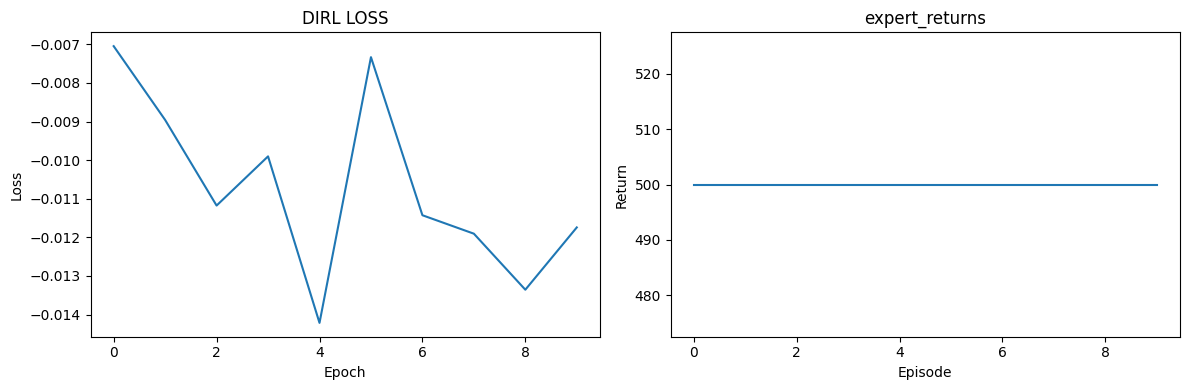

In [84]:
# 可视化训练结果
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title('DIRL LOSS')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(expert_returns)
plt.title('expert_returns')
plt.xlabel('Episode')
plt.ylabel('Return')

plt.tight_layout()
plt.show()

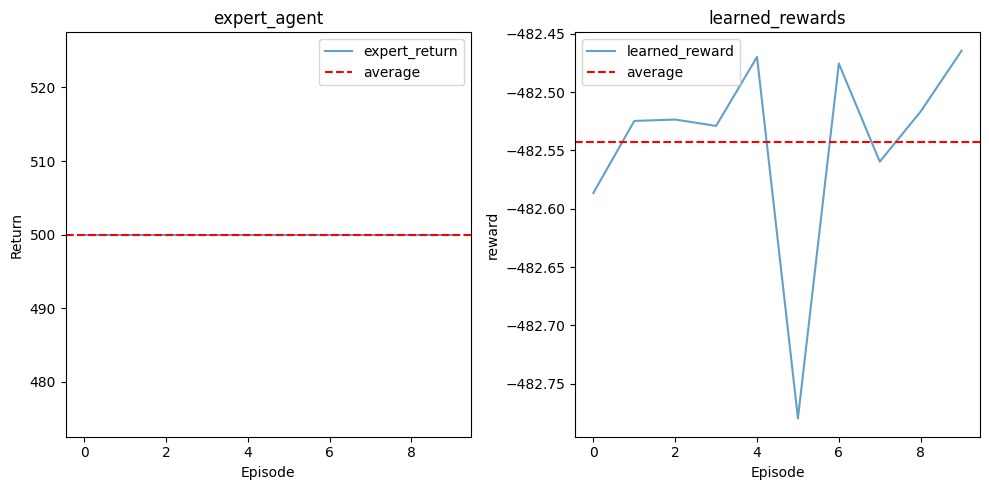

深度最大熵逆强化学习完成！


In [86]:
# 可视化对比结果
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(expert_returns, label='expert_return', alpha=0.7)
plt.axhline(y=np.mean(expert_returns), color='r', linestyle='--', label='average')
plt.title('expert_agent')
plt.xlabel('Episode')
plt.ylabel('Return')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(learned_rewards, label='learned_reward', alpha=0.7)
plt.axhline(y=np.mean(learned_rewards), color='r', linestyle='--', label='average')
plt.title('learned_rewards')
plt.xlabel('Episode')
plt.ylabel('reward')
plt.legend()

plt.tight_layout()
plt.show()

print("深度最大熵逆强化学习完成！")